In [96]:
%pip install segmentation-models-pytorch
%pip install opencv-python
%pip install seaborn
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [97]:
import cv2 
import pandas as pd 
import numpy as np 
from glob import glob 
import os  

import random 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import albumentations as album
from datetime import datetime

import segmentation_models_pytorch  
import segmentation_models_pytorch as smp
import torch as th 
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
TRAINING = True
EPOCHS = 100
BATCH_SIZE = 4 
print(DEVICE)

cuda


In [98]:
DATA_DIR = "./data/data/"
EDGE_MASK = glob(os.path.join(DATA_DIR,'road_edges_final')+'/*.png')
ROAD_MASK = glob(os.path.join(DATA_DIR,'roads_final')+'/*.png')
PROBE_MASK = glob(os.path.join(DATA_DIR,'dtrf_directions')+'/*.png')
DTRF_MASK = glob(os.path.join(DATA_DIR,'no_entry_mask') +'/*.png')

GT_MASK = glob(os.path.join(DATA_DIR,'gt_mask')+'/*.png')

print(f"RGB images {len(EDGE_MASK)} ROAD MASK images {len(ROAD_MASK)} GPS probe images {len(PROBE_MASK)} DTRF images {len(DTRF_MASK)}" )
print("Ground Truth Images ",len(GT_MASK))

RGB images 1963 ROAD MASK images 1963 GPS probe images 1963 DTRF images 2000
Ground Truth Images  1165


In [99]:
# since the number of images are different 
edge_path = [image_id.replace('gt_mask','road_edges_final') for image_id in GT_MASK]
road_path = [image_id.replace('gt_mask','roads_final') for image_id in GT_MASK]
probe_path = [image_id.replace('gt_mask','dtrf_directions') for image_id in GT_MASK]
sign_path = [image_id.replace('gt_mask','no_entry_mask') for image_id in GT_MASK]

# print(len(image_path),len(road_path),len(probe_path),len(sign_path))

images = np.asarray([(edge,probe,road,sign) for edge,probe,road,sign in zip(edge_path,probe_path,road_path,sign_path)])

print("Dataset images  :",images.shape[0])
mask_images = GT_MASK
print("GT images :",len(mask_images))

Dataset images  : 1165
GT images : 1165


In [101]:
# Get class names
class_names = ['background','no_entry_sign']
# Get class RGB values
class_rgb_values = [[0, 0, 0], [255, 255, 255]]
print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'no_entry_sign']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [11]:
# helper function for data visualization
image_id = np.random.choice(GT_MASK, 1)[0]
plt.figure(figsize=(20,10))
alpha = 0.4 


def read_image_mask(path,mask=False):
    img = cv2.imread(path)
    if mask:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


# plt.figure(figsize=(17,19))
# out_img = read_image_mask(image_id,mask=1)

# in_rgb = read_image_mask(image_id.replace('gt_mask','road_edges_final'), mask=1)
# in_probe = read_image_mask(image_id.replace('gt_mask','dtrf_directions'))
# overlay_image = cv2.addWeighted(in_rgb, alpha, in_probe, 1-alpha, 0)


# in_road = read_image_mask(image_id.replace('gt_mask','road_mask'),mask=1)
# in_sign = read_image_mask(image_id.replace('gt_mask','no_entry_mask'),mask=1 )
# overlay_mask = cv2.addWeighted(in_road, alpha*2, in_sign, 1-alpha, 0)


# plt.subplot(1,3,1)
# plt.imshow(overlay_image)

# plt.subplot(1,3,2)
# plt.imshow(overlay_mask)

# plt.subplot(1,3,3)
# plt.imshow(out_img)

<Figure size 2000x1000 with 0 Axes>

In [12]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [13]:
## combine Multi channel IMages 
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T


def combine_multi_channel_image(images_path,n_channels=6):
    channels = []
    combine_img = np.zeros([512,512,n_channels],dtype=np.uint8)
    edge_mask,probe_image,road_mask,sign_mask = images_path

    # rgb = read_image_mask(rgb_image,mask=0)
    # r,g,b = cv2.split(rgb)
    


    road = read_image_mask(road_mask,mask=1)
    edge = read_image_mask(edge_mask, mask=1)
    sign = read_image_mask(sign_mask,mask=1)

    probe = read_image_mask(probe_image,mask=0)
    pr,pg,pb = cv2.split(probe)
    
    # combine_img[:,:,0] = r
    # combine_img[:,:,1] = g
    # combine_img[:,:,2] = b
    
    combine_img[:,:,0] = road
    combine_img[:,:,1] = sign 
    combine_img[:,:,2] = edge
    combine_img[:,:,3] = pr
    combine_img[:,:,4] = pg
    combine_img[:,:,5] = pb

    return combine_img 

demo_image_paths = ['./data/data/road_edges_final/b270f986-f350-463b-8a38-bbc06ee5cd37.png',
       './data/data/dtrf_directions/b270f986-f350-463b-8a38-bbc06ee5cd37.png',
       './data/data/roads_final/b270f986-f350-463b-8a38-bbc06ee5cd37.png',
       './data/data/no_entry_mask/b270f986-f350-463b-8a38-bbc06ee5cd37.png']
combined_image  = combine_multi_channel_image(demo_image_paths)
print(combined_image.shape)

(512, 512, 6)


In [102]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, input_images_path, input_masks_path,n_channels=6 ,class_rgb_values=None, augmentation=None, preprocessing=None,image_width=512,image_height=512):
        
        self.image_paths = input_images_path
        self.mask_paths = input_masks_path
        self.class_rgb_values = class_rgb_values

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.channels = n_channels
        self.height = image_height
        self.width = image_width 
    
    def read_and_split_channels(self,path,mask=False):
        img = cv2.imread(path)
        if mask:
            return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        else:
            r,g,b  = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            return r,g,b 
        
    def create_combine_image(self,image_paths):
        combine_img = np.zeros([self.height,self.width,self.channels],dtype=np.uint8)
        edge_mask,probe_image,road_mask,sign_mask = image_paths
        
        road = self.read_and_split_channels(road_mask,mask=True)
        sign = self.read_and_split_channels(sign_mask,mask=True)
        edge = self.read_and_split_channels(edge_mask,mask=True)
        pr,pg,pb = self.read_and_split_channels(probe_image,mask=False)



        # combine_img[:,:,0] = r
        # combine_img[:,:,1] = g
        # combine_img[:,:,2] = b
        
        combine_img[:,:,0] = road
        combine_img[:,:,1] = sign 
        combine_img[:,:,2] = edge
        combine_img[:,:,3] = pr
        combine_img[:,:,4] = pg
        combine_img[:,:,5] = pb

        return combine_img 

    def __getitem__(self, i):
        # read images and masks
        image = self.create_combine_image(self.image_paths[i]) # NxWxH (6x512x512)
        image = image.astype(np.float32)/255.0
        
        # print(self.mask_paths[i])
        gt_mask = cv2.imread(self.mask_paths[i],cv2.COLOR_BGR2GRAY)
        gt_mask = gt_mask/255.0
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=gt_mask)
            image, gt_mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            gt_mask = np.expand_dims(gt_mask,axis=-1)
            # print(f"sending {image.shape} {gt_mask.shape}")
            sample = self.preprocessing(image=image, mask=gt_mask)
            image, gt_mask = sample['image'], sample['mask']
        return image ,gt_mask 

    def __len__(self):
        # return length of images dataset 
        return self.image_paths.shape[0]

In [81]:
images_path = [demo_image_paths]
input_masks_path = ['./data/data/no_entry_mask/b270f986-f350-463b-8a38-bbc06ee5cd37.png']
dataset = SignDataset(images_path, input_masks_path, class_rgb_values=class_rgb_values, preprocessing= get_preprocessing(preprocessing_fn),
    image_width = 512,
    image_height = 512)

image, mask = dataset[0]

print(image.shape ,mask.shape )

plt.figure(figsize=(15,10))

plt.subplot(1,5,1)
plt.title('Road Mask Image')
plt.imshow(image[:,:,0],cmap='gray')

plt.subplot(1,5,2)
plt.imshow(image[:,:,1],cmap='gray')
plt.title('Heading mask')

plt.subplot(1,5,3)
plt.title('Road Edge Mask')
plt.imshow(image[:,:,2], cmap='gray')


plt.subplot(1,5,4)
plt.imshow(image[:,:,3:6])
plt.title('Probe mask')

# plt.subplot(1,5,5)
# plt.imshow(mask,cmap='gray')
# plt.title('Ground Truth Road Element')

adding prep {preprocessing_fn} to transforms
./data/data/no_entry_mask/b270f986-f350-463b-8a38-bbc06ee5cd37.png
sending (224, 224, 6) (224, 224, 1)


ValueError: operands could not be broadcast together with shapes (224,224,6) (3,) 

<class 'numpy.ndarray'>
(512, 512, 6) (512, 512)


Text(0.5, 1.0, 'Ground Truth Road Element')

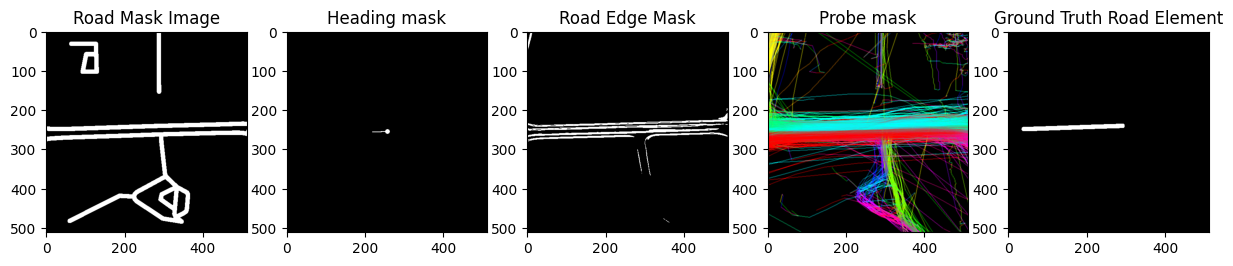

In [103]:
# print(images)
dataset = SignDataset(images, mask_images, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[14]
print(type(image))
print(image.shape ,mask.shape )

plt.figure(figsize=(15,10))

plt.subplot(1,5,1)
plt.title('Road Mask Image')
plt.imshow(image[:,:,0],cmap='gray')

plt.subplot(1,5,2)
plt.imshow(image[:,:,1],cmap='gray')
plt.title('Heading mask')

plt.subplot(1,5,3)
plt.title('Road Edge Mask')
plt.imshow(image[:,:,2], cmap='gray')


plt.subplot(1,5,4)
plt.imshow(image[:,:,3:6],cmap='gray')
plt.title('Probe mask')

plt.subplot(1,5,5)
plt.imshow(mask,cmap='gray')
plt.title('Ground Truth Road Element')

In [105]:
def get_training_augmentation():
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
                # album.OneOf([album.CLAHE(p=1),album.RandomBrightness(p=1),album.RandomGamma(p=1)],p=0.9)
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    if preprocessing_fn:
        # print("adding prep {preprocessing_fn} to transforms")
        _transform = [
            album.Lambda(image=preprocessing_fn),
            album.Lambda(image=to_tensor, mask=to_tensor),
        ]
    else:
        # print("no prep added to transforms")
        _transform = [
            album.Lambda(image=to_tensor,mask=to_tensor),
            # transforms.Normalize(mean, std)

        ]
    return album.Compose(_transform)

(512, 512, 6) (512, 512)


Text(0.5, 1.0, 'Ground Truth Road Element')

<Figure size 1000x1500 with 0 Axes>

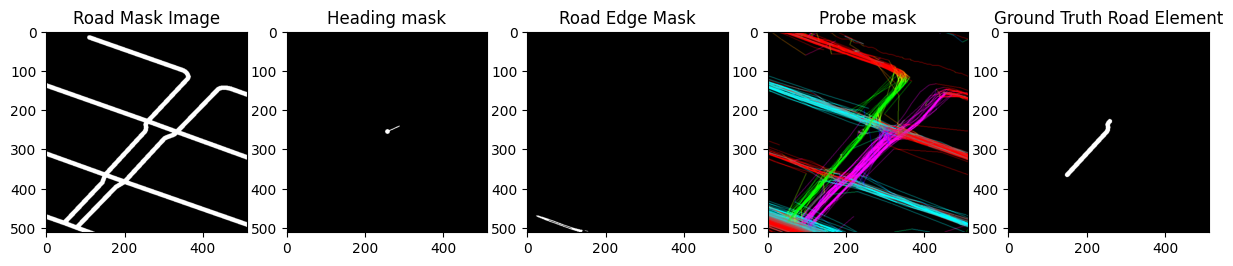

In [106]:
augmented_dataset = SignDataset(images, mask_images, augmentation=get_training_augmentation())

random_idx = random.randint(0, len(augmented_dataset)-1)
count = 0
plt.figure(figsize=(10,15))

image, mask = augmented_dataset[random_idx]

print(image.shape ,mask.shape )

plt.figure(figsize=(15,10))

plt.subplot(1,5,1)
plt.title('Road Mask Image')
plt.imshow(image[:,:,0],cmap='gray')

plt.subplot(1,5,2)
plt.imshow(image[:,:,1],cmap='gray')
plt.title('Heading mask')

plt.subplot(1,5,3)
plt.title('Road Edge Mask')
plt.imshow(image[:,:,2], cmap='gray')


plt.subplot(1,5,4)
plt.imshow(image[:,:,3:6],cmap='gray')
plt.title('Probe mask')


plt.subplot(1,5,5)
plt.imshow(mask,cmap='gray')
plt.title('Ground Truth Road Element')

In [107]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = "imagenet"
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

In [108]:
# # create segmentation model with pretrained encoder
# resnet50_model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes= 1, 
#     activation=ACTIVATION,
#     in_channels = 6
# )

# create segmentation model with pretrained encoder
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,Sequential
 
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn_block = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=3,kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=1,stride=1,padding=1)
        )
        self.unet = smp.Unet(
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHTS,
                classes= 1,
                activation=ACTIVATION,
                in_channels = 3
                )
 
    def forward(self,x):
        x = self.cnn_block(x)
        return self.unet(x)
 
model_cnn = CNNModel()

In [109]:
# Add pre-processing function for Resnet 
if ENCODER_WEIGHTS=='imagenet':
    print("setting prep")
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    print(preprocessing_fn)

setting prep
functools.partial(<function preprocess_input at 0x7f28d58d0040>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [110]:
train_dataset = SignDataset(images, mask_images,
    augmentation= get_training_augmentation(),
    preprocessing= get_preprocessing(),
    image_width = 512,
    image_height = 512
    )
image, mask = train_dataset[0]
print(image.shape,mask.shape)

(6, 512, 512) (1, 512, 512)


In [111]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [112]:
import torch.nn.functional as F 
import segmentation_models_pytorch.utils as smp_utils
import segmentation_models_pytorch.utils.metrics as metrics  

# define loss function
ALPHA = 0.8
GAMMA = 2

loss1 = smp.losses.DiceLoss(mode='binary')
loss1.__name__='Dice_loss'
loss2 = smp.losses.FocalLoss(mode='binary')
# loss  = segmentation_models_pytorch.losses.DiceLoss(mode='binary')
loss2.__name__ = 'Focal_loss'


metrics = [metrics.IoU(threshold=0.5)]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model_cnn.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [113]:
train_epoch = segmentation_models_pytorch.utils.train.TrainEpoch(
    model_cnn, 
    loss=loss2, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [114]:
%%time
best_iou_score= 0.0
train_logs_list, valid_logs_list = [], []
for i in range(0,EPOCHS):
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(train_loader)
    train_logs_list.append(train_logs)
    torch.save(model_cnn, f'./model/model_ep_{i}.pth')
    # Save model if a better val IoU score is obtained
    if best_iou_score < train_logs['iou_score']:
        best_iou_score = train_logs['iou_score']
        torch.save(model_cnn, f'./model/best_model_ep_{i}.pth')
        print('Model saved!') 


Epoch: 1
train: 100%|██████████| 292/292 [00:47<00:00,  6.10it/s, Focal_loss - 0.2317, iou_score - 0.009425]
Model saved!

Epoch: 2
train: 100%|██████████| 292/292 [00:47<00:00,  6.09it/s, Focal_loss - 0.1954, iou_score - 0.004655]

Epoch: 3
train: 100%|██████████| 292/292 [00:47<00:00,  6.11it/s, Focal_loss - 0.1864, iou_score - 0.001688]

Epoch: 4
train: 100%|██████████| 292/292 [00:48<00:00,  6.00it/s, Focal_loss - 0.1817, iou_score - 0.0009223]

Epoch: 5
train: 100%|██████████| 292/292 [00:47<00:00,  6.08it/s, Focal_loss - 0.1791, iou_score - 0.0006788]

Epoch: 6
train: 100%|██████████| 292/292 [00:49<00:00,  5.94it/s, Focal_loss - 0.1774, iou_score - 0.0008959]

Epoch: 7
train: 100%|██████████| 292/292 [00:48<00:00,  6.00it/s, Focal_loss - 0.1764, iou_score - 0.0007347]

Epoch: 8
train: 100%|██████████| 292/292 [00:49<00:00,  5.88it/s, Focal_loss - 0.1757, iou_score - 0.000673] 

Epoch: 9
train: 100%|██████████| 292/292 [00:48<00:00,  6.01it/s, Focal_loss - 0.1751, iou_score - 0.

In [14]:
model = torch.load('./model/best_model.pth', map_location=DEVICE)
model = model.to(DEVICE)
model.eval()  # Set the 

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [47]:
_transform = [
            album.Lambda(image=to_tensor)
            # transforms.Normalize(mean, std)

        ]
transformss = album.Compose(_transform)

input_tensor = torch.from_numpy(transformss(image=combined_image)["image"]).unsqueeze(0).to(DEVICE)
print(type(input_tensor))
print(input_tensor.shape)
# Run inference
with torch.no_grad():
    output = model(input_tensor)
    np_array = output.cpu().numpy()
    print(np_array.max())
    print(np_array.shape)

<class 'torch.Tensor'>
torch.Size([1, 6, 512, 512])
1.0
(1, 1, 512, 512)


In [52]:
np_array = np_array[0, 0, :, :]
cv2.imwrite("./demo_ex.png", (np_array*255).astype(np.uint8))

True